# The day typing pipeline 

The pipeline finds consumption profile prototypes and estimates a distance metric that translates calendar information (month of year and day of week) to daily or sub-daily consumption profile similarity. Prototypes are a small set of daily or sub-daily profiles that adequately summarize the available data. 

All the predictive models for estimating the baseline energy consumption of a building work by exploiting the daily, weekly and yearly seasonality of the consumption data. Some models make the assumption that this seasonality can be identified across the whole dataset, whereas others assume that each calendar month is so distinct from the others that it should have its own monthly model. 

In contrast, the proposed approach makes no a priori assumptions regarding the daily, weekly and yearly similarities between the different observations in the dataset. Instead, it relies on the day typing stage to distinguish all the days in the available dataset into different categories according to the shape and scale of their energy consumption profiles. 

In [1]:
import math 
import calendar
import functools
import matplotlib.cm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from datetime import time
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from feature_encoders.generate import DatetimeFeatures

A plotting utility:

In [2]:
def get_colors(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cmap(ind)
    else:
        return cmap(np.linspace(0,1,N))

In [3]:
from eensight.utils.jupyter import load_catalog
from eensight.pipelines.daytype import get_matrix_profile, find_prototypes
from eensight.pipelines.daytype import learn_distance_metric, metric_function
from eensight.features import MMCFeatures

### Select and read a preprocessed dataset from the data catalog

In [4]:
catalog = load_catalog('demo', partial_catalog=True)

In [5]:
train_data = catalog.load('train.preprocessed_data')

2021-11-17 21:43:37,838 - kedro.io.data_catalog - INFO - Loading data from `train.preprocessed_data` (CSVDataSet)...


### Categorization of consumption profiles

For the day typing process:

 - Outliers are replaced by `NaN`
 - All (whole) days where `NaN`s exceed one third of the observations are removed
 - The remaining `NaN`s are imputed

In [6]:
consumption = train_data[['consumption']].mask(train_data['consumption_outlier'], np.nan)

remove = consumption['consumption'].isna().groupby(lambda x: x.date()).sum() > 0.33
consumption = consumption[~np.isin(consumption.index.date, remove[remove].index)]

consumption = (consumption[['consumption']].interpolate(method='slinear')
                                           .fillna(method='bfill')
                                           .fillna(method='ffill')
)

The consumption profiles of all the days in the dataset is presented next:

In [7]:
consumption['date'] = consumption.index.date
consumption['time'] = consumption.index.time

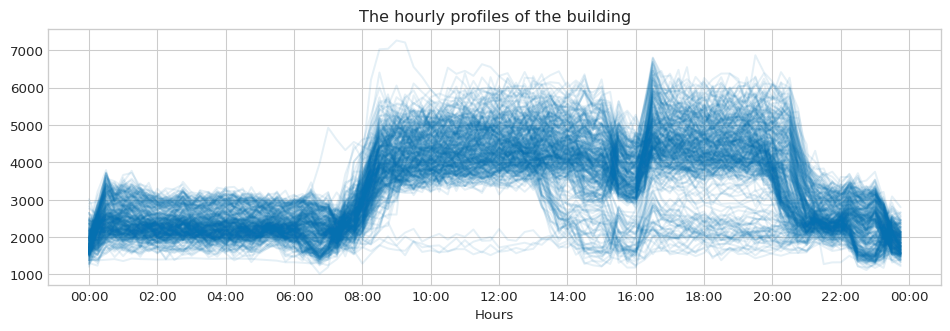

In [8]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption.pivot(index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.1, legend=None, color='#0570b0')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

The matrix profile is a measure of energy consumption predictability. The following plot presents the matrix profile values of all the subsequences in the consumption data of the building that: (a) have length $m$ that corresponds to one day (this means that $m=24$ for hourly data or $m=96$ for 15-min data), and (b) start at 00:00 hours, so that to only compare subsequences that span a full day’s period. The plot reflects a very well behaved building. Most values are low and only a few peaks are present. This implies that a lot of daily consumption profiles are similar to each other, and only a few of them are very different. 

Similar load profiles imply that similar activities take place inside a building. So, if we only have energy consumption and outdoor air temperature data (and this is very limited data), we can “help” our predictive model by asking it to focus on data with strong covariance. 

In [9]:
X = consumption['consumption']

In [10]:
#window corresponds to number of hours no matter the time granularity of the dataset 
profile = get_matrix_profile(X, window=24) 

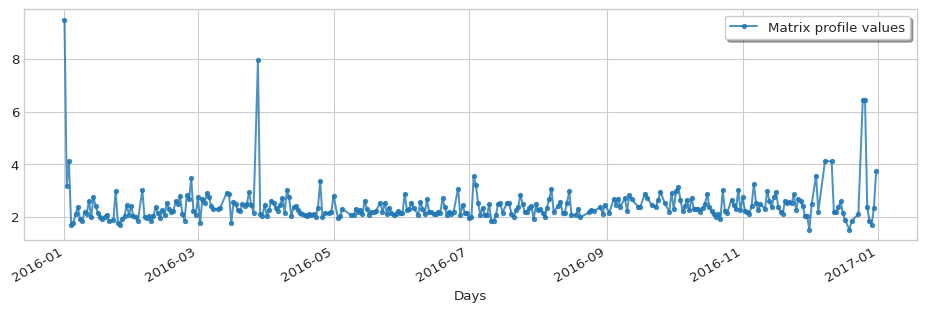

In [11]:
start_time = time(0, 0)
profile_daily = profile[profile.index.time == start_time]

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    profile_daily['nnd'].plot(ax=ax, style='-o', ms=3, alpha=0.8)
    ax.legend(['Matrix profile values'], frameon=True, shadow=True)
    ax.set_xlabel('Days')

We can isolate the days that look very dissimilar compared to all the others (discords). A discord is a consumption profile that is very different to all the other profiles in the dataset. In some cases, a discord is the result of outliers in metered data that escaped the preprocessing stage. In other cases, the respective profiles correspond to national holidays and the dataset does not contain enough instances of these holidays.

In [12]:
discords = profile_daily[profile_daily['nnd'] >= profile_daily['nnd'].quantile(0.99)]
discords = consumption.loc[np.isin(consumption.index.date, discords.index.date)]

In this case, discords are days where no activity takes place in the building and consumption varies randomly around the baseload. If there is no pattern to pick up, day typing will characterize such a day as a discord:

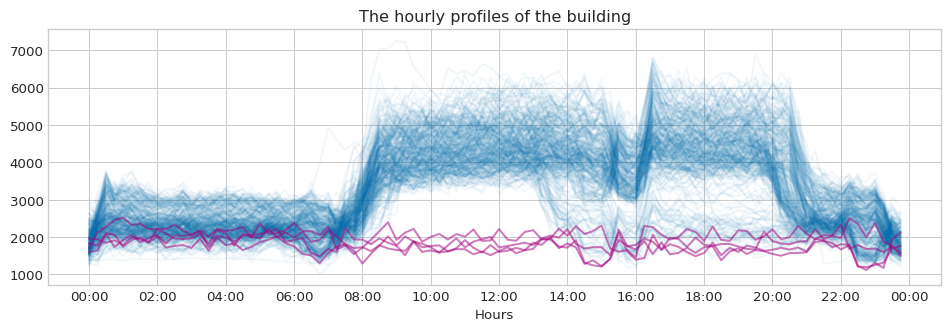

In [13]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    consumption.pivot(index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.05, legend=None, color='#0570b0')
    
    discords.pivot(index='time', columns='date', values='consumption') \
               .plot(ax=ax, alpha=0.5, legend=None, color='#ae017e')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

The information about the matrix profile score of each day in the dataset can be stored so that we can evaluate whether the baseline model does a good job at predicting the consumption of discords. If it does not, either additional information should be sought for the discord days or a different model can be applied on the discord dataset.  

The day typing method can be applied on complete daily profiles or on any number of non-overlapping daily intervals. Here, we assume three (3) non-overlapping 8-hour intervals: *00:00-08:00*, *08:00-16:00* and *16:00-00:00*.

In [14]:
window = 8
time_step = X.index.to_series().diff().min()
steps_per_hour = math.ceil(pd.Timedelta('1H') / time_step)
m = window * steps_per_hour
print(f'Each window of {window} hours includes {m} observations')

Each window of 8 hours includes 32 observations


In [15]:
profile = get_matrix_profile(X, window=window)

In [16]:
intervals = {}

#### Interval #1: `00:00-08:00`

In [17]:
start_time = time(0, 0)
end_time = time(8, 0)

We are searching for daily profiles that adequately summarise the available data. The key idea behind this approach is to identify a small number of recurring patterns (prototypes) that are very dissimilar to each other and can be used as points of reference for comparing all the remaining daily or sub-daily consumption profiles found in the dataset. 

The proposed methodology for day typing builds upon the distance and matrix profile data structures: 

> [Chin-Chia Michael Yeh, Y. Zhu, L. Ulanova, N. Begum, Y. Ding, H. A. Dau, D. F. Silva, A. Mueen, and E. Keogh (2016) “Matrix profile I: All pairs similarity joins for time series: a unifying view that includes motifs, discords and shapelets,” in 2016 IEEE 16thInternational Conference on Data Mining (ICDM), IEEE, pp. 1317–1322](https://www.semanticscholar.org/paper/Matrix-Profile-I%3A-All-Pairs-Similarity-Joins-for-A-Yeh-Zhu/a68271101067d91412bec50d71e1191c9be679fb)

In [18]:
prototype_results = find_prototypes(X, profile, start_time, end_time=end_time, max_iter=30)

Since we aim at a small number of prototypes, we need a criterion for stopping this process and filtering out redundant patterns. To this end, we monitor the value of the squared maximum mean discrepancy (MMD) between the distribution of the energy consumption in the selected prototypes and the distribution of the energy consumption in all data. The (unbiased) squared MMD is calculated as:

$$MMD^2=\frac{1}{m(m-1)}\sum_{i,j=1}^{m} k(z_i, z_j)-\frac{2}{mn}\sum_{i,j=1}^{m,n} k(z_i, x_j)+\frac{1}{n(n-1)}\sum_{i,j=1}^{n} k(x_i, x_j)$$

where:

$m$ is the number of all prototypes selected after each iteration

$n$	is the number of all daily profiles in the time interval under study

$z$	is a matrix with all prototypes

$x$	is a matrix with all daily profiles in the time interval under study

$k(∙)$ is a kernel function.

The closer the squared MMD is to zero, the better the distribution of the prototypes fits the data. The next plot shows the progression of the squared MMD as we add more prototypes. The first data point of the plot corresponds to two (2) prototypes already selected (we cannot calculate the MMD with only one prototype).

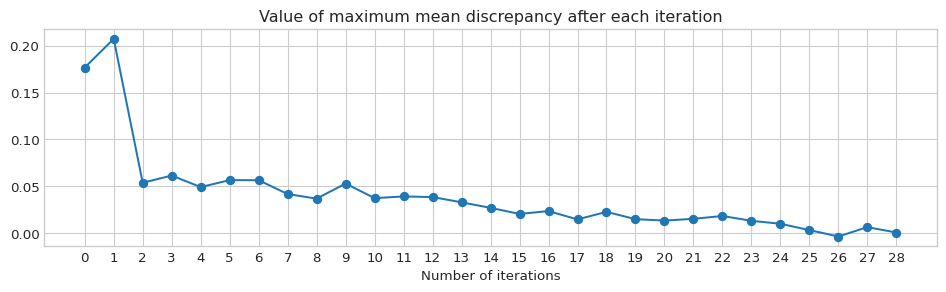

In [19]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    stopping_metric = pd.Series(prototype_results.mmd_scores)
    stopping_metric.plot(ax=ax, xticks=stopping_metric.index, style='-o')
    ax.set_xlabel('Number of iterations')
    ax.set_title('Value of maximum mean discrepancy after each iteration')

We stop the prototype selection process the first time the absolute value of the MMD remains under 0.1 for two consecutive steps.

In [20]:
selected = ((stopping_metric.abs() < 0.1).rolling(2).sum() == 2).idxmax() + 1

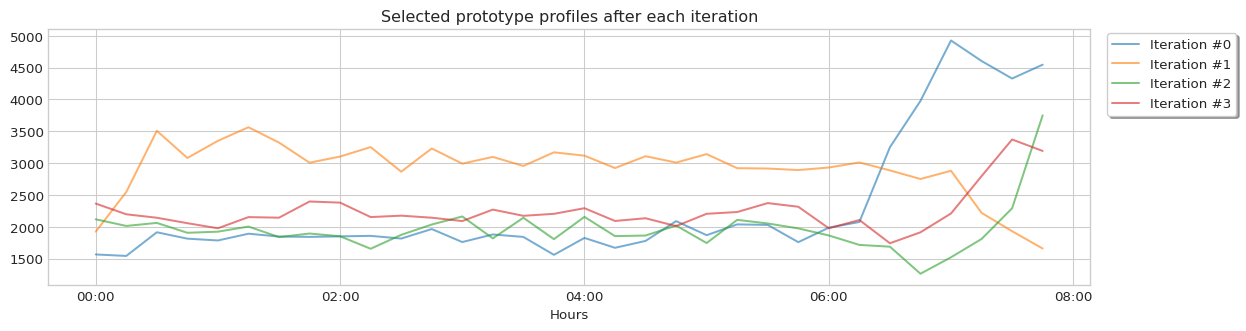

In [21]:
with plt.style.context('seaborn-whitegrid'): 
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    for i, min_idx in enumerate(prototype_results.prototypes[:selected]):
        prototype = X[min_idx:min_idx+m]
        prototype.index = prototype.index.map(lambda x: x.time)
        prototype.plot(label=f'Iteration #{i}', alpha=0.6)
    
    ax.set_xlabel('Hours')
    ax.set_title('Selected prototype profiles after each iteration')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    
    ax.legend(loc='best', ncol=1, frameon=True, shadow=True, bbox_to_anchor=(1.01, 1.01))

The distances of each daily profile to each of the prototypes could be used as a way to cluster days. However, since consumption data is only available during the training of the predictive model, our goal is to translate the information about consumption profile similarity into information that can be constructed using daily-level data that is only available during prediction time:

*	Day of the week: An ordinal feature taking values from 0 (Monday) to 6 (Sunday);
*	Month of the year: An ordinal feature taking values from 1 to 12.

This implies a need for a clustering process that uses a specific kind of distance metric: one that given calendar information about two observations considers them close if their daily profiles are similar. To this end, the proposed methodology makes use of distance metric learning. Distance metric learning aims at automatically constructing task-specific distance metrics from (weakly) supervised data. In this case, the derived distance metric is just a function that gets the aforementioned time-based features as inputs and returns the similarity in the respective load shapes.

The underlying algorithm [Jason V. Davis, Brian Kulis, Prateek Jain, Suvrit Sra, and Inderjit S. Dhillon (2007) "Information-theoretic metric learning," In Proceedings of the 24th international conference on Machine learning (ICML '07), pp. 209–216](https://dl.acm.org/doi/10.1145/1273496.1273523) takes inputs `X` and target `y` as:

- `X`: Each input data point is a pair of calendar days, each expressed as the corresponding month and day of week. The encoding scheme is presented below:

  <img src="images/mmc.png?modified=12345678" alt="grouped" width="600"/>
  
  
- `y`: The target value for each pair is either 1 if the energy consumption profiles of the corresponding days are similar or -1 if they are not. 

The encoding of the calendar information is done in a way similar to the following:

In [22]:
mcc_features = Pipeline([
        ('dates', DatetimeFeatures(subset=['month', 'dayofweek'], remainder='drop')),
        ('features', MMCFeatures()),
])

features = mcc_features.fit_transform(consumption)
features.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
timestamp,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-01 00:15:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-01 00:30:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-01 00:45:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2016-01-01 01:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


According to the standard approach for predictive model evaluation, part of the pairs is used for training the distance metric learning algorithm and part is used only for evaluating its performance on unseen data. For the evaluation, we test whether given the time information of two observations (day of week and month of year), the model can accurately predict whether their load profiles are similar or not. We can treat it as a binary classification problem, and the `learn_distance_metric` function returns the [Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) for this evaluation. If the score is not satisfactory, a different than the proposed modelling approach can be pursued.

In [23]:
%%time

distances = prototype_results.distance_from_prototypes.iloc[:, :selected]
metric_results = learn_distance_metric(distances, pairs_per_prototype=50, test_size=0.1)
metric_results.score

Wall time: 2.76 s


0.8557250996811163

We can create a distance metric:

In [24]:
metric = functools.partial(metric_function, metric_results.metric_components)

... and use it to cluster the observations and derive the different day types of the dataset:

In [25]:
%%time

features = mcc_features.fit_transform(distances)
clusterer = DBSCAN(metric=metric, eps=0.1)
clusterer = clusterer.fit(features)

Wall time: 297 ms


In [26]:
clusters = pd.Series(data=clusterer.labels_, index=features.index.date)

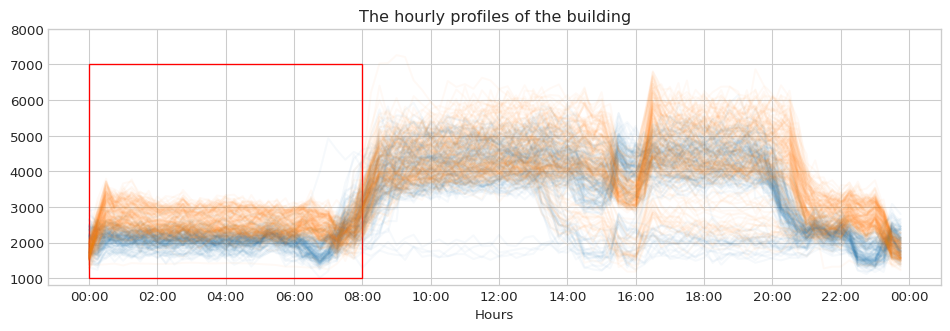

In [27]:
colors = get_colors('tab10', N=clusters.nunique())

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for cat in sorted(clusters.unique()):
        if cat == -1:
            continue
        grouped = clusters[clusters==cat]
        mask = np.isin(consumption.index.date, grouped.index)
    
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.04, legend=None, color=colors[cat])
    
    grouped = clusters[clusters==-1]
    if len(grouped) > 0:
        mask = np.isin(consumption.index.date, grouped.index)
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.1, legend=None, color=colors[-1])
    
    rect = patches.Rectangle((0, 1000), 28800, 6000, linewidth=1, 
                             edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.set_ylim(800, 8000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

Store the information:

In [28]:
intervals[0] = {
    'start_time': start_time,
    'end_time': end_time,
    'metric_components': metric_results.metric_components
}

#### Interval #2: `08:00-16:00`

In [29]:
start_time = time(8, 0)
end_time = time(16, 0)

In [30]:
prototype_results = find_prototypes(X, profile, start_time, end_time=end_time, max_iter=30)

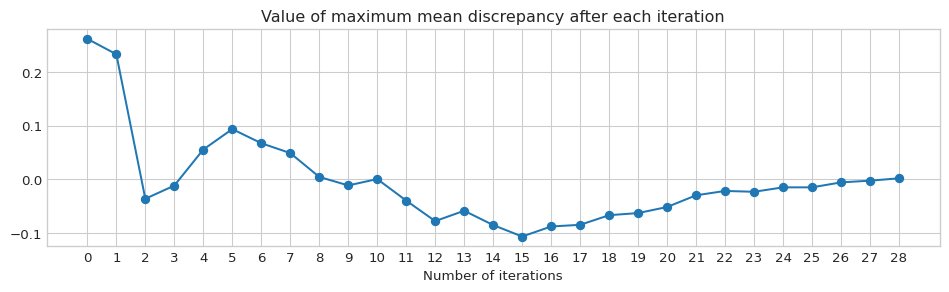

In [31]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    stopping_metric = pd.Series(prototype_results.mmd_scores)
    stopping_metric.plot(ax=ax, xticks=stopping_metric.index, style='-o')
    ax.set_xlabel('Number of iterations')
    ax.set_title('Value of maximum mean discrepancy after each iteration')

In [32]:
selected = ((stopping_metric.abs() < 0.1).rolling(2).sum() == 2).idxmax() + 1

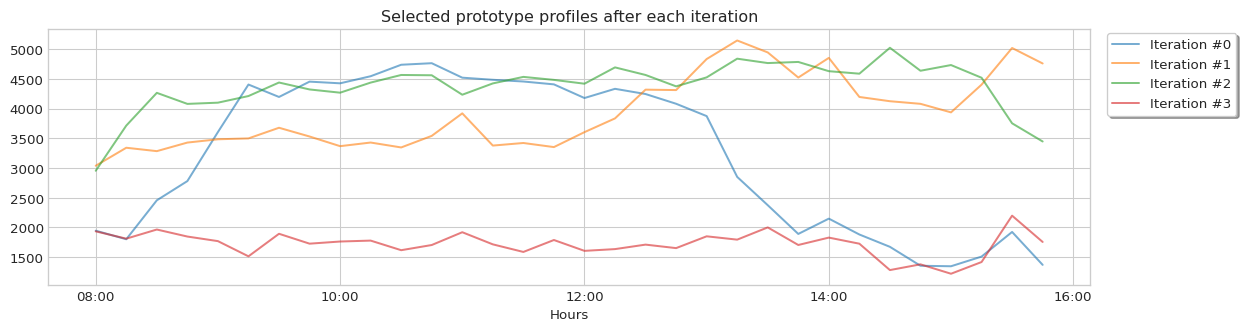

In [33]:
with plt.style.context('seaborn-whitegrid'): 
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    for i, min_idx in enumerate(prototype_results.prototypes[:selected]):
        prototype = X[min_idx:min_idx+m]
        prototype.index = prototype.index.map(lambda x: x.time)
        prototype.plot(label=f'Iteration #{i}', alpha=0.6)
    
    ax.set_xlabel('Hours')
    ax.set_title('Selected prototype profiles after each iteration')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    
    ax.legend(loc='best', ncol=1, frameon=True, shadow=True, bbox_to_anchor=(1.01, 1.01))

In [34]:
distances = prototype_results.distance_from_prototypes.iloc[:, :selected]
metric_results = learn_distance_metric(distances, pairs_per_prototype=50, test_size=0.1)
metric_results.score

0.8567910533443431

We can create a distance metric:

In [35]:
metric = functools.partial(metric_function, metric_results.metric_components)

... and use it to cluster the observations and derive the different day types of the dataset:

In [36]:
%%time

features = mcc_features.fit_transform(distances)
clusterer = DBSCAN(metric=metric, eps=0.05)
clusterer = clusterer.fit(features)

Wall time: 298 ms


In [37]:
clusters = pd.Series(data=clusterer.labels_, index=features.index.date)

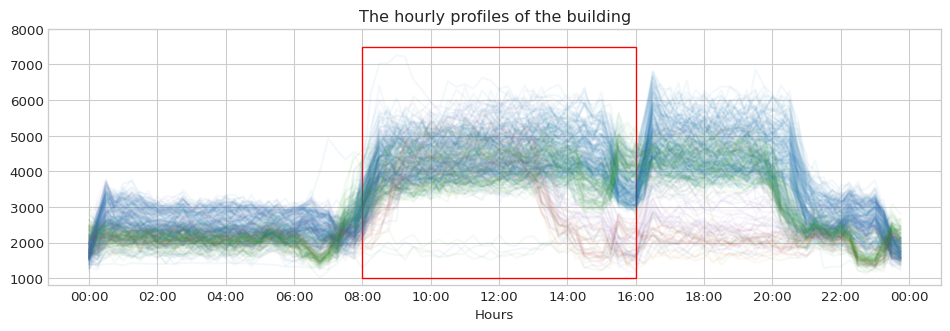

In [38]:
colors = get_colors('tab10', N=clusters.nunique())

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for cat in sorted(clusters.unique()):
        if cat == -1:
            continue
        grouped = clusters[clusters==cat]
        mask = np.isin(consumption.index.date, grouped.index)
    
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.05, legend=None, color=colors[cat])
    
    grouped = clusters[clusters==-1]
    if len(grouped) > 0:
        mask = np.isin(consumption.index.date, grouped.index)
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.05, legend=None, color=colors[-1])
    
    
    rect = patches.Rectangle((28800, 1000), 28800, 6500, linewidth=1, 
                             edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.set_ylim(800, 8000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

In [39]:
intervals[1] = {
    'start_time': start_time,
    'end_time': end_time,
    'metric_components': metric_results.metric_components
}

#### Interval #3: `16:00-00:00`

In [40]:
start_time = time(16, 0)
end_time = time(0, 0)

In [41]:
prototype_results = find_prototypes(X, profile, start_time, end_time=end_time, max_iter=30)

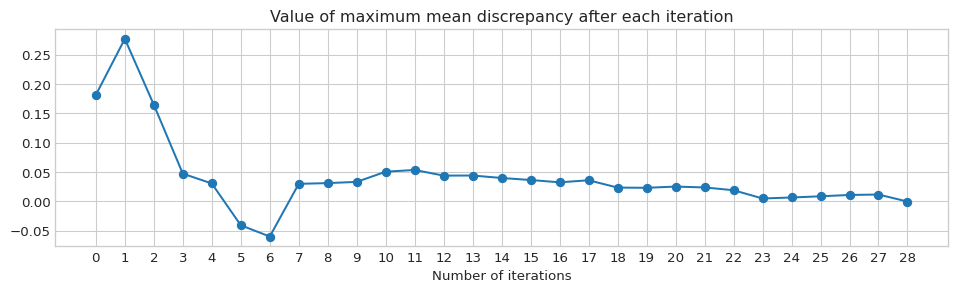

In [42]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    stopping_metric = pd.Series(prototype_results.mmd_scores)
    stopping_metric.plot(ax=ax, xticks=stopping_metric.index, style='-o')
    ax.set_xlabel('Number of iterations')
    ax.set_title('Value of maximum mean discrepancy after each iteration')

In [43]:
selected = ((stopping_metric.abs() < 0.1).rolling(2).sum() == 2).idxmax() + 1

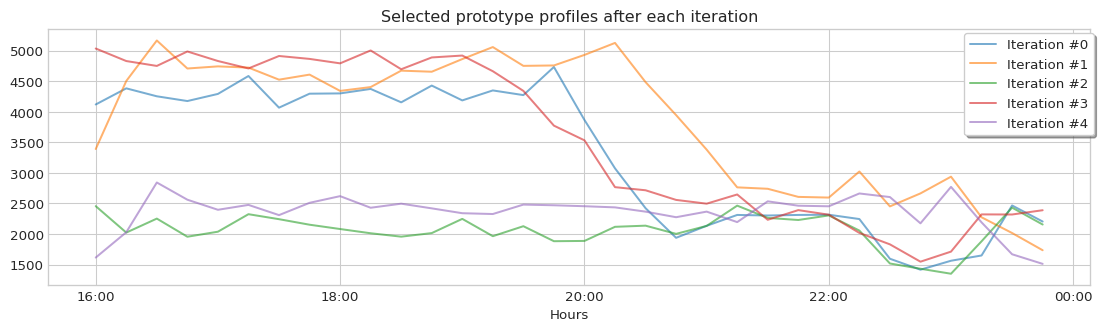

In [44]:
with plt.style.context('seaborn-whitegrid'): 
    fig = plt.figure(figsize=(14, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    for i, min_idx in enumerate(prototype_results.prototypes[:selected]):
        prototype = X[min_idx:min_idx+m]
        prototype.index = prototype.index.map(lambda x: x.time)
        prototype.plot(label=f'Iteration #{i}', alpha=0.6)
    
    ax.set_xlabel('Hours')
    ax.set_title('Selected prototype profiles after each iteration')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    
    ax.legend(loc='best', ncol=1, frameon=True, shadow=True, bbox_to_anchor=(1.01, 1.01))

In [45]:
distances = prototype_results.distance_from_prototypes.iloc[:, :selected]
metric_results = learn_distance_metric(distances, pairs_per_prototype=50, test_size=0.1)
metric_results.score

0.7079361616697484

In [46]:
metric = functools.partial(metric_function, metric_results.metric_components)

features = mcc_features.fit_transform(distances)
clusterer = DBSCAN(metric=metric, eps=0.1)
clusterer = clusterer.fit(features)

clusters = pd.Series(data=clusterer.labels_, index=features.index.date)

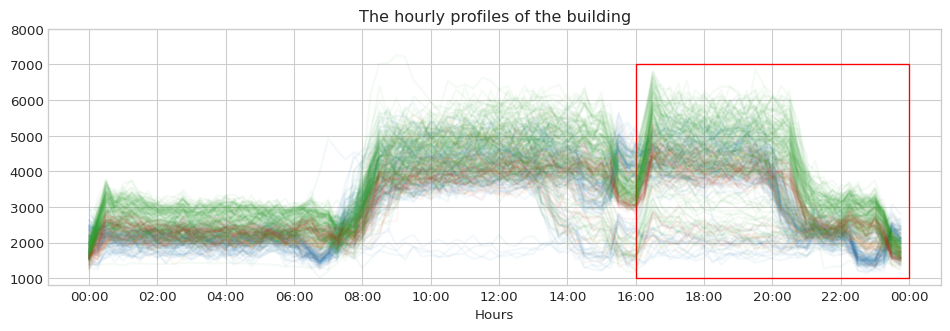

In [47]:
colors = get_colors('tab10', N=clusters.nunique())

with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    for cat in sorted(clusters.unique()):
        if cat == -1:
            continue
        grouped = clusters[clusters==cat]
        mask = np.isin(consumption.index.date, grouped.index)
    
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.05, legend=None, color=colors[cat])
    
    grouped = clusters[clusters==-1]
    if len(grouped) > 0:
        mask = np.isin(consumption.index.date, grouped.index)
        consumption[mask].pivot(index='time', columns='date', values='consumption') \
                   .plot(ax=ax, alpha=0.05, legend=None, color=colors[-1])
    
    
    rect = patches.Rectangle((57600, 1000), 28800, 6000, linewidth=1, 
                                 edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.set_ylim(800, 8000)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
    ax.set_xlabel('Hours')
    ax.set_title('The hourly profiles of the building')

In [48]:
intervals[2] = {
    'start_time': start_time,
    'end_time': end_time,
    'metric_components': metric_results.metric_components
}

### Save to catalog

In [49]:
catalog.save('train.matrix_profile_scores', profile_daily)
catalog.save('train.distance_metrics', intervals)

2021-11-17 12:21:48,810 - kedro.io.data_catalog - INFO - Saving data to `train.matrix_profile_scores` (CSVDataSet)...
2021-11-17 12:21:48,836 - kedro.io.data_catalog - INFO - Saving data to `train.distance_metrics` (PickleDataSet)...


----------------